# Treinando um modelo de linguagem Transformer do zero em partidas anotadas de xadrez


## 1. Treinando o *tokenizer*

O vocabulário de escolha do presente notebook são as possíveis anotações de lances do formato PGN. Ao todo são mais de 14700 palavras que representam lances (ex: e4, Nf3, c5, d4xe5, e8=Q, etc.).

Antes é preciso instalar as bibliotecas *transformers* e *tokenizers* da Huggingface.


In [ ]:
!pip uninstall -y tensorflow
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'

Daí montamos a pasta do Google Drive, que guardará os arquivos de treinamento do modelo e do tokenizer, além da nossa base de partidas.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Para treinar o tokenizer, especificaremos o nosso vocabulário a partir de um arquivo que contém todos os tokens possíveis. Passaremos a lista consistindo desses tokens como tokens especiais e passeremos um caminho de arquivo qualquer com poucas anotações de partidas apenas para preencher o argumento de treino do tokenizer.

In [ ]:
%%time 
from pathlib import Path

from tokenizers import Tokenizer
from tokenizers.models import Unigram
from tokenizers.pre_tokenizers import Whitespace

base_dir = '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks'
paths = ['/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/MacKenzie.pgn_simplified.spgn',
         '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/twic1431g/twic1431.pgn_simplified.spgn']

tokenizer = Tokenizer(Unigram())
tokenizer.pre_tokenizer = Whitespace()

with open(f'{base_dir}/complete_vocab.txt', 'r') as f:
  vocab = f.read().split('\n')

vocab += ["<s>", "<pad>", "</s>", "<unk>", "<mask>"]

# tokenizer.train(files=paths, vocab_size=len(vocab), min_frequency=1, special_tokens=vocab)
from tokenizers.trainers import UnigramTrainer
trainer = UnigramTrainer(vocab_size=len(vocab), special_tokens=vocab)
tokenizer.train(files=paths, trainer=trainer)

['/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/MacKenzie.pgn_simplified.spgn', '/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/twic1431g/twic1431.pgn_simplified.spgn']
CPU times: user 927 ms, sys: 1 s, total: 1.93 s
Wall time: 1.72 s


Abaixo segue um exemplo de tokenização de uma entrada representando um começo de partida de xadrez.

In [ ]:
output = tokenizer.encode("e4 e5 Nf3 Nf6 d4 Nxe4 Bd3 d5 dxe5")
print(output.tokens)
print(len(vocab))

['e4', 'e5', 'Nf3', 'Nf6', 'd4', 'Nxe4', 'Bd3', 'd5', 'dxe5']
14731


Salvaremos o tokenizer no nosso diretório principal, especificado pela variável **model_dir**.

In [ ]:
model_dir = "/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnGPT"
tokenizer.model.save(model_dir)
tokenizer.save(f"{model_dir}/tokenizer.json")

In [ ]:
# # from tokenizers.implementations import ByteLevelBPETokenizer
# # from tokenizers.implementations import Tokenizer
# from tokenizers.processors import BertProcessing


# # tokenizer = ByteLevelBPETokenizer(
# #     "./pgnBERT/vocab.json",
# #     "./pgnBERT/merges.txt",
# # )
# tokenizer = Tokenizer.from_file(
#     f"{model_dir}/tokenizer.json"
# )

# # print(tokenizer.pad_token)
# # tokenizer.mask_token = "<mask>"

In [ ]:
# tokenizer._tokenizer.post_processor = BertProcessing(
#     ("</s>", tokenizer.token_to_id("</s>")),
#     ("<s>", tokenizer.token_to_id("<s>")),
# )
# tokenizer.enable_truncation(max_length=512)

In [ ]:
# tokenizer.encode("e4 e5 Nf3 Nf6 d4")
# tokenizer.encode("e4 e5 Nf3 Nf6 d4").tokens

## 2. Treinando o modelo de linguagem

Poderemos treinar um *Masked Language Model* (MLM), tais como BERT e derivados, ou um *Causal Language Model* (CLM), tais como GPT. Pouca coisa muda quando usamos as bibliotecas da Huggingface.

A seguir treinamos uma versão da arquitetura GPT-2 do zero.

Primeiro, veremos se a GPU está disponível.

In [1]:
!nvidia-smi

Wed May 25 01:28:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
torch.cuda.is_available()

True

Agora definiremos a configuração do modelo. 15011 é o tamanho do vocabulário mais alguns tokens especiais.

In [ ]:
# from transformers import RobertaConfig

# RoBERTa:
# config = RobertaConfig(
#     vocab_size=15011,
#     max_position_embeddings=514,
#     num_attention_heads=12,
#     num_hidden_layers=6,
#     type_vocab_size=1,
# )

# GPT-2:
from transformers import GPT2Model, GPT2Config, GPT2LMHeadModel

# Initializing a GPT2 configuration
configuration = GPT2Config(
    vocab_size=15011
)

O tokenizer treinado e salvo anteriormente será carregado na forma de um GPT2TokenizerFast.

In [ ]:
# from transformers import RobertaTokenizerFast

# RoBERTa:
# tokenizer = RobertaTokenizerFast.from_pretrained(model_dir, max_len=512)

# GPT-2:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained(model_dir, max_len=512)
print(tokenizer.mask_token)

<mask>


Da primeira vez que o código é executado, o tokenizer ainda não possui alguns dos tokens especiais (BOS, EOS, PAD, UNK e MASK). Daí é preciso descomentar e executar a célula a seguir, que adiciona os novos tokens ao tokenizer.

In [ ]:
# tokenizer.bos_token = "<s>"
# tokenizer.pad_token = "<pad>"
# tokenizer.eos_token = "</s>"
# tokenizer.unk_token = "<unk>"
# tokenizer.mask_token = "<mask>"
# tokenizer.save_pretrained(model_dir)

Agora inicializeremos o modelo.

É importante destacar que não inicializaremos o modelo a partir de um treinado em linguagem natural, pois nosso objetivo é treinar nas partidas de xadrez em formato PGN.

Na primeira execução, é preciso descomentar e executar a célula abaixo.

In [ ]:
# from transformers import RobertaForMaskedLM

# Para RoBERTa:
# model = RobertaForMaskedLM(config=config)

# Para GPT-2:
# model = GPT2LMHeadModel(config=configuration)

Caso o modelo já tenha sido treinado e salvo, é possível carregá-lo:

In [ ]:
# from transformers import RobertaForMaskedLM

# RoBERTa:
# model = RobertaForMaskedLM.from_pretrained("/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/pgnBERT")

# GPT-2:
model = GPT2LMHeadModel.from_pretrained(model_dir)

print(model.num_parameters())

97370880


### Criando o Dataset de treino

Precisaremos definir a nossa própria classe de dataset herdando da classe Dataset do PyTorch. Faremos isso por questões de escalabilidade, visto que usar um LineByLineTextDataset requer que um arquivo com todas as partidas seja carregado inteiro na memória.

O nosso CustomTextDataset lê as partidas de uma forma diferente: todas as partidas são distribuídas em 2000 arquivos, de modo que em um dado momento apenas parte das partidas precisa estar na memória.

In [ ]:
from torch.utils.data import Dataset
from transformers import PreTrainedTokenizer
from typing import Dict
from glob import glob
from functools import lru_cache
import os

class CustomTextDataset(Dataset):
  def __init__(self, tokenizer: PreTrainedTokenizer, dir_path: str, block_size: int):
    if not os.path.isdir(dir_path):
      raise ValueError(f"Input dir path {dir_path} not found")
    self._tokenizer = tokenizer
    self._block_size = block_size
    file_paths = glob(dir_path + "/*")
    self._dir_path = dir_path
    self._shard_len = 1000
    self._len = 0
    for file_path in file_paths:
      with open(file_path, encoding="utf-8") as f:
        self._len += sum(1 for line in f if len(line) > 2)
    self._mem = {}
    print(self._len)

  def __len__(self):
    return self._len

  def __getitem__(self, i) -> Dict[str, torch.tensor]:
    if i in self._mem:
      return self._mem[i]

    shard = i // self._shard_len
    eg = i % self._shard_len
    fname = f'{self._dir_path}/{shard}.cpgn'

    lines = []
    with open(fname, encoding="utf-8") as f:
      for idx, line in enumerate(f):
        if len(line) > 2:
          lines.append(line)

    batch_encoding = self._tokenizer(lines, add_special_tokens=True, truncation=True, max_length=self._block_size)
    examples = batch_encoding["input_ids"]
    examples = [{"input_ids": torch.tensor(e, dtype=torch.long)} for e in examples]

    for idx in range(len(examples)):
      self._mem[shard * self._shard_len + idx] = examples[idx]

    return examples[eg]

In [ ]:
%%time
# from transformers import LineByLineTextDataset

# dataset = LineByLineTextDataset(
#     tokenizer=tokenizer,
#     file_path="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/clean_joint_100.cpgn",
#     block_size=128,
# )

dataset = CustomTextDataset(
    tokenizer=tokenizer,
    dir_path="/content/drive/MyDrive/Unicamp/IA 376L - 2022.1/notebooks/cpgn",
    block_size=128,
)

1820744
CPU times: user 1.33 s, sys: 472 ms, total: 1.8 s
Wall time: 18.8 s


O data collator será usado na criação de batches de treino.

In [ ]:
from transformers import DataCollatorForLanguageModeling

# RoBERTa:
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer, mlm=True, mlm_probability=0.15
# )

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False
)

Agora inicializaremos nosso objeto Trainer, que é responsável pelo treino do modelo. O objeto TrainingArguments é usado para especificar parâmetros do treino como diretório de saída, número de épocas, tamanho do batch e outros.

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir=model_dir,
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_gpu_train_batch_size=32,
    save_steps=2000,
    save_total_limit=2,
    prediction_loss_only=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset,
)

Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.


Agora iniciaremos o treino propriamente dito.

In [ ]:
%%time
trainer.train()

Salvaremos o modelo no nosso diretório para que possa ser carregado e usado depois, tanto para continuar o treino quanto para fazer inferência.

In [ ]:
trainer.save_model(model_dir)

## 3. Checando o modelo treinado

Quando usamos um CLM, a parte generativa (decoder) retorna a probabilidade de cada palavra no vocabulário dadas as palavras anteriores (prompt). A seguir usaremos os escores da saída do método **generate** para criar partidas baseadas em diferentes estratégias de amostragem. A mais simples delas é a *greedy*, onde cada novo token é gerado e concatenado aos últimos. Outra forma de amostrar sequências de tokens consiste em pegar os próximos *k* tokens com maior probabilidade conjunta (dados os anteriores). O caso onde *k = 1* equivale ao greedy.

Primeiro instalaremos a biblioteca python-chess, que será útil para validar as saídas do modelo, de modo que apenas partidas válidas sejam geradas.

In [ ]:
!git clone https://github.com/niklasf/python-chess.git
!cd python-chess; git checkout 46b1b0a6a1a7feda89775fc861a9b15fb5581740
!cd python-chess; pip install -e .

In [ ]:
import chess
import chess.pgn as pgn
import chess.svg
import io
import random
import numpy as np
from copy import copy

Agora definiremos alguns métodos auxiliares e métodos para as diferentes técnicas de amostragem citadas.

In [ ]:
game_end = ['1-0', '0-1', '1/2-1/2']

def is_legal(board, move):
  try:
    san_move = board.parse_san(move)
  except ValueError as e:
    return False
  return san_move in board.legal_moves

def gen_next_greedy(prompt, prob_mass=0.7, random_seed=0):
  input_ids = tokenizer(prompt, return_tensors="pt")
  input_ids = input_ids.input_ids
  input_ids = input_ids.to(model.device)
  outputs = model.generate(
      input_ids,
      do_sample=False,
      max_length=len(input_ids[0]) + 1,
      output_scores=True,
      return_dict_in_generate=True,
      pad_token_id=tokenizer.eos_token_id
  )
  scores = outputs.scores[0].detach().cpu().numpy()[0]
  prob_scores = np.exp(scores) / sum(np.exp(scores))
  next_ids = np.argsort(scores)
  acc_prob = 0.0
  top_ids = []
  for idx in range(len(next_ids) - 1, -1, -1):
    if acc_prob >= prob_mass:
      break
    acc_prob += prob_scores[next_ids[idx]]
    top_ids.append(next_ids[idx])
  top_scores = prob_scores[top_ids]
  outputs = tokenizer.batch_decode(torch.tensor([top_ids], device=model.device))
  outputs = outputs[0]
  ans = {'tokens': outputs.split(' '), 'probabilities': top_scores}
  return ans

def generate_greedy(prompt):
  board = chess.Board()
  for move in prompt.split(' '):
    board.push_san(move)
  for _ in range(200):
    moves = gen_next_greedy(prompt, prob_mass=0.7)
    norm_probs = moves['probabilities'] / sum(moves['probabilities'])
    new_moves = np.random.choice(
        moves['tokens'],
        size=len(moves['tokens']),
        replace=False,
        p=norm_probs
    )
    idx = 0
    while idx < len(new_moves) and not is_legal(board, new_moves[idx]):
      idx += 1
    if idx == len(new_moves):
      new_move = '1/2-1/2'
      prompt += ' ' + new_move
      break
    new_move = new_moves[idx]
    prompt += ' ' + new_move
    board.push_san(new_move)
  return prompt

def generate_best_next(prompt, k=4, prob_mass=0.7):
  moves = gen_next_greedy(prompt, prob_mass)
  moves, probs = moves['tokens'], moves['probabilities']
  board = chess.Board()
  for move in prompt.split(' '):
    if len(move) > 0:
      board.push_san(move)
  if k <= 1:
    idx = 0
    while idx < len(moves) and not is_legal(board, moves[idx]):
      idx += 1
    if idx < len(moves):
      return np.log(probs[idx]), moves[idx]
    else:
      print(prompt)
      print(moves)
      print(probs)
      input()
      return float('-inf'), ''
  max_score = float('-inf')
  max_moves = None
  for move, prob in zip(moves, probs):
    if is_legal(board, move):
      sub_score, sub_moves = generate_best_next(
          prompt + ' ' + move,
          k - 1,
          prob_mass
      )
      curr_score = np.log(prob) + sub_score
      if curr_score > max_score:
        max_score = curr_score
        if len(sub_moves) > 0:
          max_moves = move + ' ' + sub_moves
        else:
          max_moves = move
  if max_moves is None:
    return float('-inf'), ''
  return max_score, max_moves

def generate_best(prompt):
  pass

Finalmente podemos gerar algumas partidas.

In [ ]:
start = 'c4'
num_moves = 25
k = 12
num_iter = num_moves // k
for _ in range(num_iter):
  new_moves = generate_best_next(start, k=k, prob_mass=0.3)[1]
  print(new_moves)
  start += ' ' + new_moves
print(start)

# print(generate_greedy(start))

---

In [ ]:
prompt = 'e4'
board = chess.Board()
board.push_san(prompt)
board.__str__().replace('\n', ' | ') + ' > '

'r n b q k b n r | p p p p p p p p | . . . . . . . . | . . . . . . . . | . . . . P . . . | . . . . . . . . | P P P P . P P P | R N B Q K B N R > '

In [ ]:
# print(generate_game(first_move='b3', depth=1, max_moves=1))

# depth = 1
# moves = generate('e4', k=depth, how='greedy', random_seed=1)

prompt = 'e4'
board = chess.Board()
board.push_san(prompt)
for _ in range(40):
  moves = gen_next_greedy(prompt, prob_mass=0.7)
  norm_probs = moves['probabilities'] / sum(moves['probabilities'])
  new_moves = np.random.choice(
      moves['tokens'],
      size=len(moves['tokens']),
      replace=False,
      p=norm_probs
  )
  idx = 0
  while idx < len(new_moves) and not is_legal(board, new_moves[idx]):
    idx += 1
  if idx == len(new_moves):
    new_move = '1/2-1/2'
    prompt += ' ' + new_move
    break
  new_move = new_moves[idx]
  prompt += ' ' + new_move
  board.push_san(new_move)
print(prompt)

# print(moves)
# for idx in range(2, 10):
#   moves = generate(moves, k=idx*depth, how='beam')
#   print(moves)

# Código antigo de exploração

In [ ]:
def generate(prompt, k=30, how='greedy', random_seed=0):
  input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)
  # sample up to 30 tokens
  torch.manual_seed(random_seed)
  if how == 'greedy':
    outputs = model.generate(
        input_ids,
        do_sample=False,
        max_length=k,
        output_scores=True,
        return_dict_in_generate=True
    )
    print(outputs)
    print(outputs.scores[0][0])
    print(outputs.sequences[0])
    # print(outputs.scores[0][0, outputs.sequences[0, 0]])
    print(outputs.scores[0][0, outputs.sequences[0, -1]])
    print(max(outputs.scores[0][0]))
    outputs = outputs.sequences
    outputs = tokenizer.batch_decode(outputs)
  elif how == 'beam':
    outputs = model.generate(
        input_ids,
        num_beams=100,
        do_sample=True,
        max_length=k,
        output_scores=True,
        return_dict_in_generate=True
    )
    outputs = tokenizer.batch_decode(outputs)
  else:
    outputs = model.generate(input_ids, do_sample=True, max_length=k)
    outputs = tokenizer.batch_decode(outputs) # , skip_special_tokens=True
  outputs = outputs[0]
  return outputs

def generate_game(first_move='e4', depth=5, max_moves=30, how='beam'):
  prompt = first_move
  board = chess.Board()
  board.push_san(first_move)
  for _ in range(0, max_moves, depth):
    moves = generate(prompt, k=len(prompt.split(' ')) + depth, how=how)
    moves = moves[len(prompt):]
    moves = moves.split(' ')
    for move in moves:
      if is_legal(board, move):
        board.push_san(move)
        prompt += ' ' + move
      else:
        break
  return prompt

In [ ]:
from transformers import pipeline

fill_mask = pipeline(
    "fill-mask",
    model=model_dir,
    tokenizer=model_dir,
    top_k=8,
)

In [ ]:
def sample_next_k(board, position, k):
  if k <= 0:
    return 0, []
  moves = fill_mask(' '.join(position) + ' <mask>')
  # moves = fill_mask(' '.join(position))
  print(moves)
  moves = [move for move in moves if move['token_str'] not in game_end]
  max_score = float('-inf')
  max_seq = []
  for move in moves:
    if is_legal(board, move['token_str']):
      board.push_san(move['token_str'])
      position.append(move['token_str'])
      score, subseq = sample_next_k(
          board,
          position,
          k - 1
      )
      score += np.log(move['score'])
      subseq.insert(0, move['token_str'])
      board.pop()
      position.pop()
      if score > max_score:
        max_score = score
        max_seq = copy(subseq)
  return max_score, max_seq

In [ ]:
board = chess.Board()
game = []
for move in game:
    board.push_san(move)
for i in range(20):
  _, moves = sample_next_k(board, game, 4)
  print(moves)
  for move in moves:
    game.append(move)
    board.push_san(move)
    if board.is_fivefold_repetition():
      break
print(' '.join(game))

In [ ]:
game = ['c4', 'e5']

board = chess.Board()
for move in game:
  board.push_san(move)

for i in range(200):
  idx = 0
  found = True
  moves = fill_mask(' '.join(game) + ' <mask>')
  moves = [move for move in moves if move['token_str'] not in game_end]
  # if random.randint(0, 10) > 8:
  #   random.shuffle(moves)
  print(' '.join([move['token_str'] for move in moves]))
  move = moves[idx]['token_str']
  while not is_legal(board, move):
    idx += 1
    # moves = fill_mask(' '.join(game) + ' <mask>')
    # print(moves)
    # input()
    if idx < len(moves):
      move = moves[idx]['token_str']
    else:
      found = False
      break
  # print(idx, end=' ')
  if found and is_legal(board, move):
    # print(idx, move, board.parse_san(move) in board.legal_moves)
    game.append(move)
    board.push_san(move)
    if board.is_fivefold_repetition():
      break
  else:
    break

In [ ]:
game_str = ''
for idx, move in enumerate(game):
  if idx % 2 == 0:
    game_str += f'{idx // 2 + 1}. {move} '
  else:
    game_str += f'{move} '
game_str += '  1/2-1/2'
print(game_str)

1. c4 e5 2. e4 Nc6 3. Nf3 Nf6 4. d3 Bc5 5. Nbd2 O-O 6. g3 a6 7. Bg2 d6 8. O-O Re8 9. Re1 h6 10. h3 Ba7 11. a3 Bc5 12. Rb1 Ba7 13. b4 Ne7 14. Bb2 Ng6 15. Qc2 c6 16. d4 Qe7 17. d5 c5 18. b5 a5 19. a4 b6 20. Qb3 Bb7 21. Qc2 Bc8 22. Qb3 Bd7 23. Qc2 Bc8 24. Qb3 Bd7 25. Qc2 Bg4 26. Qb3 Bc8 27. Qc2 Bd7 28. Qb3 Bc8 29. Qc2 Bd7 30. Qb3 Bc8 31. Qc2 Bd7 32. Qb3 Bc8 33. Qc2 Bd7 34. Qb3 Bc8   1/2-1/2


In [ ]:
from PIL import Image
from cairosvg import svg2png
from glob import glob

In [ ]:
def make_gif(gif_fn, frames):
  frames = sorted(frames, key=lambda x: int(x.split('_')[-1].split('.')[-2]))
  frames = [Image.open(image) for image in frames]
  frame_one = frames[0]
  frame_one.save(
      gif_fn,
      format="GIF",
      append_images=frames,
      save_all=True,
      duration=1000,
      loop=0
  )

In [ ]:
# pgn = io.StringIO('1. e4 Nf6 2. Nf3 e6 3. d4 e5  1/2-1/2')
# game_str = '1. e4 c5 2. c4 e6 3. Nf3 d5 4. e5 Nc6 5. d4 Nh6 6. Nbd2 Nf5 7. Bd3 Be7 8. O-O O-O 9. b3 Na5 10. Bb2 b6 11. a3 Bb7 12. Qe2 Rc8 13. Bb1 c4'
pgn = io.StringIO(game_str)
game = chess.pgn.read_game(pgn)
board = game.board()

In [ ]:
# svg2png(bytestring=chess.svg.board(board), write_to=f'boards/board_0.png')
# with open('boards/board_0.svg', 'w') as f:
#     f.write(chess.svg.board(board))
for idx, move in enumerate(game.mainline_moves()):
    board.push(move)
    # board_svg = chess.svg.board(board)
    # svg2png(bytestring=board_svg, write_to=f'boards/board_{idx + 1}.png')
    # with open(f'boards/board_{idx + 1}.svg', 'w') as f:
    #   f.write(board_svg)

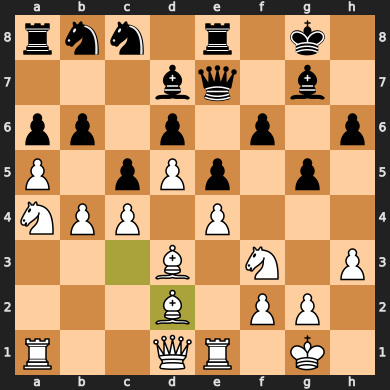

In [ ]:
board

In [ ]:
make_gif('board.gif', glob(f'boards/*.png'))

Ok, simple syntax/grammar works. Let’s try a slightly more interesting prompt:



## 5. Share your model 🎉

Finally, when you have a nice model, please think about sharing it with the community:

- upload your model using the CLI: `transformers-cli upload`
- write a README.md model card and add it to the repository under `model_cards/`. Your model card should ideally include:
    - a model description,
    - training params (dataset, preprocessing, hyperparameters), 
    - evaluation results,
    - intended uses & limitations
    - whatever else is helpful! 🤓

### **TADA!**

➡️ Your model has a page on http://huggingface.co/models and everyone can load it using `AutoModel.from_pretrained("username/model_name")`.

[![tb](https://huggingface.co/blog/assets/01_how-to-train/model_page.png)](https://huggingface.co/julien-c/EsperBERTo-small)


If you want to take a look at models in different languages, check https://huggingface.co/models

[![all models](https://huggingface.co/front/thumbnails/models.png)](https://huggingface.co/models)
